# CITS5508 labsheet 5
**Name: Zhanhong He** (or Zhanh He)<br>
**Student number: 22597343**<br>
**Date created:** 19 April 2021<br>
**Last modified:** 21 May 2021<br>

In [4]:
# Import DataLoader from given py document
from data_loader import DataLoader
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping,LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model,save_model,Sequential

# 1. Load Dataset and Inspection
**DataLoader** for loading CIFAR-10 data is given in the `data_loader.py`, while the module **DataLoader** has the following two built-in functions:<br>

1\.`__load_pickle_file(filename)`<br>
+ This function reads the given pickle file in the current directory and returns a dictionary object.
+ Parameter is the pickle file namename.


2\.`load_batch(filename_prefix,Nbatches=5, ...)`
+ This function reads the Nbatches files and returns two numpy arrays X and y.
+ According to the CIFAR-10 website, the training set is split into 5 batches stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There are 10 classes.
+ Other arguements `height=32, width=32, Nchannels=3` set as default.

In [5]:
# Each colour image has dimensions equal to 32 x 32 x 3. 
image_width,image_height,image_Nchannels = 32, 32, 3

# There are 10 classes
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Other arguments of the load_batch function have been set
X_train_load, y_train_load = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

# Inspect the train and test set we loaded
print('X_train_load.shape =', X_train_load.shape, 'data type:', X_train_load.dtype)
print('y_train_load.shape =', y_train_load.shape, 'data type:', y_train_load.dtype)
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_train_load.shape = (50000, 32, 32, 3) data type: float32
y_train_load.shape = (50000,) data type: uint8
X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


# 2. Split Dataset and Visualisation
The image pixel values are already normalised to [0,1] by `DataLoader.load_batch` function, so the further feature scaling is not required. Using **80/20** ratio to  random split the train set we loaded, results in the **new train set** (80% of origin) and the **validation set**. The original test set we loaded are kept, so we have 3 types of dataset after spliting:
1. `X_train`: new train set obtained by spliting
2. `X_valid`: validation set obtained by spliting
3. `X_test`: original test set we loaded

While the **X set contains many images** and the **y set contains their labels**.

In [6]:
# 2.1 - Split the new train and validation (test) set - 80/20 ratio
X_train, X_valid, y_train, y_valid = train_test_split(X_train_load, y_train_load,
                                                                    test_size=0.2, random_state=1)

For visulisation, we are required to write an function to display **20 images (2 rows and 10 columns)** randomly selected from the **Train set, Validation set, and Test set**.

In [7]:
# 2.2 - Display (rows * columns) random images from the selected dataset

def dataset_sample_images(images,labels,rows,cols,dataset_name):
    ''' 
    images: the set of images - X_train, X_valid, X_test
    labels: the set of labels - y_train, y_valid, y_test
    rows, cols: the rows and columns for display
    dataset_type: 'train set', 'validation set', 'test set'
    '''
    num = rows * cols                         # Define number of images to display
    plt.figure(figsize=(20,5))
    print(f"Randomly {num} images randomly selected from the {dataset_name}")
    
    for i in range(num):
        ii = random.randint(0,len(images)-1)  # Reindex
        image = images[ii]                    # Select single image
        label = labels[ii]                    # Select their label
        ax = plt.subplot(rows,cols,i+1)       # One by one subplot
        plt.imshow(image)
        plt.axis('off')
        ax.set_title(class_names[label])
    plt.show()

Randomly 20 images randomly selected from the Train set


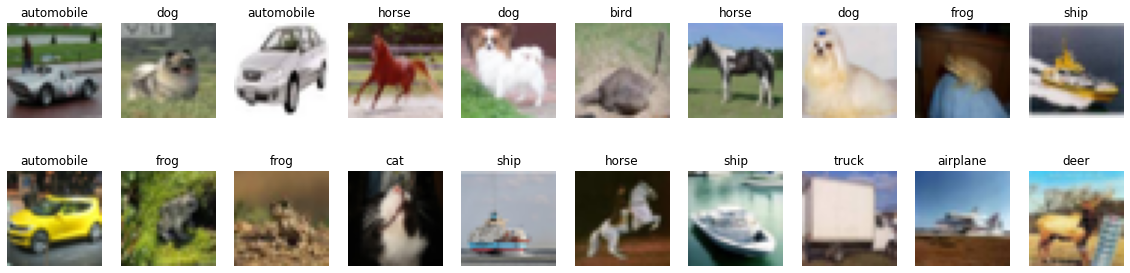

Randomly 20 images randomly selected from the Validation set


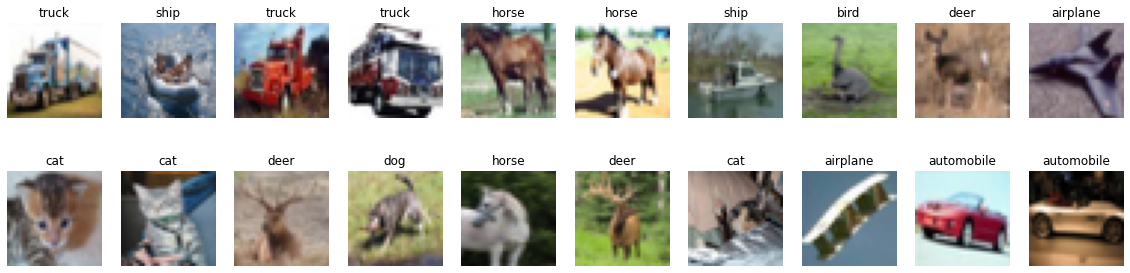

Randomly 20 images randomly selected from the Test set


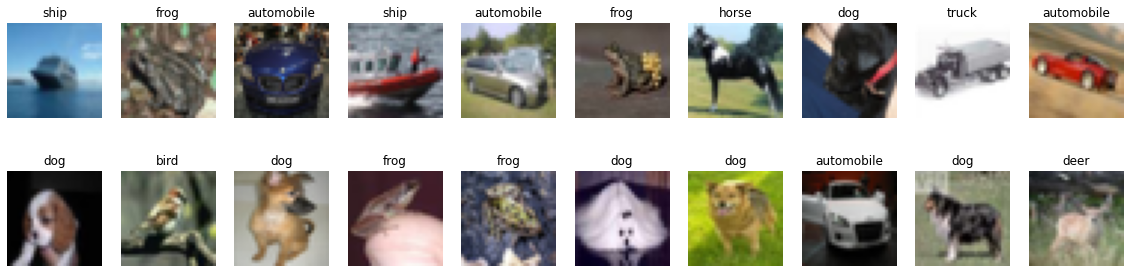

In [8]:
# Display 20 images randomly selected from the train set (2 rows x 10 cols)
dataset_sample_images(X_train, y_train, 2, 10, 'Train set')

# From the validation set
dataset_sample_images(X_valid, y_valid, 2, 10, 'Validation set')

# From the test set
dataset_sample_images(X_test, y_test, 2, 10, 'Test set')

# 3. MLP Implementation
## 3.1 Design MLP Architecture
The MLP is composed of an input layer, one or more hidden layers, and an output layer with fully connected structure. In this Lab, the instruction has mentioned that:
1. Given **input layer** has the fixed shape (32,32,3) -- flatten to 3072.
2. Decide **2-3 hidden layers & activation function**,  with fewer neurons than previous layer (avoid overfit).
3. Decide **an output layer & activation function**,  with 10 neurons corresponding to 10 classes animals and vehicles, etc..

### Hidden Layers
Since the input has been flatten to 3072 neurons, we should arrange less neurons in those Hidden Layers. In my design, the First Hidden Layer has 512 neurons while the Second Hidden Layer has 256 neurons.

Although I tried adding a third hidden layer, or more neurons per hidden layer, the improvement was too small to accept. Therefore, I decided to keep this simple structure for the fast training speed, facilitating parameters optimization. There are two popular activation functions for the Modern MLP hidden layers:
+ The hyperbolic tangent function: $tanh(z)=2 \sigma (2z-1)$. Output of each layer is centred on 0 and distributed between $[-1,1]$.
+ The rectified linear unit function: $ReLU(z)=max(0,z)$. Output is distributed between the interval $[0,1]$, with fast compute speed.

ReLU has the advantage of speed and prevention of gradient disappearance, thus becoming the default setting for hidden layers in modern networks. ReLU has several improved variants nowaday, such as LeakyReLU as well as PReLU; they are designed to handle errors when the input $z<0$. However, the input data has been normalised into the interval $[0,1]$ by `DataLoader`, so we can simply use **ReLU** without further consideration.

### Output Layer
Our MLP is designed to identify the images of 10 classes, so the Output Layer only has 10 neurons corresponding to each class of animals. According to the ***Table 10-2. Typical classification MLP architecture*** \[1, p.295\], we should use the **SoftMax** as the output layer activation because of doing the multiclass classification.

In [9]:
# 3.1 - Design MLP architecture

def build_mlp_model(kernel_initializer,learning_rate,dropout_rate):
    '''
    Parameters for optimal:
    > kernel_initializer = 'glorot_uniform'(default),'glorot_normal','he_uniform','he_normal'           
    > learning_rate = 0.001, 0.01(default), 0.1, ...
    > dropout_rate = 0.1, 0.2(default), 0.3, ...
    '''
    # Build the model
    mlp_model = Sequential([
        # Flatten the Input
        keras.layers.Flatten(input_shape=(32,32,3),name='Flatten'),
        # First Hidden Layer（less neurons） - ReLU activation
        keras.layers.Dense(512, activation='relu',name='Hidden_1st'),
        # Second Hidden Layer (less neurons) - ReLU activation
        keras.layers.Dense(256, activation='relu',name='Hidden_2nd'),
        # Output Layer - Softmax activation
        keras.layers.Dense(10, activation='softmax',name='Output_Softmax') 
    ],name='MLP_model')
    
    # Compile the model (learning_rate used here)
    mlp_model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mlp_model

## 3.2 Optimal Parameters
After the structure has been decided, we need to optimise some parameters to obtain the best performance, such as the `connection weight initialisation`, `learning rate scheduling` and `dropout rate`. **The GridSearchCV for explore optimal hyparameters has been commented out.**
```python
# Use GridSearchCV to optimal parameters
mlp_model = KerasClassifier(build_fn=build_mlp_model,verbose=0)
mlp_param = dict(kernel_initializer=['he_normal','he_uniform','glorot_normal','glorot_uniform'],
                learning_rate=[0.001,0.01,0.1],
                dropout_rate = [0.1, 0.2, 0.3])

mlp_grid = GridSearchCV(estimator=mlp_model,param_grid=mlp_param,n_jobs=-1,cv=3)
grid_result = mlp_grid.fit(X_valid,y_valid,epochs=100)
grid_result.best_params_
```

### Connection weight initialisation
Default `kernel_initializer` in Keras is `glorot_uniform`, but there are many initializers are built, such as `glorot_normal`, `he_uniform`, and `he_normal`. According to ***Table 10-2. Typical classification MLP architecture*** \[1, p.334\], He initialisations would be the most suitable for ReLU and its variants, while Glorot initialisations are more suitable for several others (including Softmax). We will try the GridSearch to explore the best option.

### [Learning rate scheduling](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)
Learning rate controls how much to change the model in response to the estimated error each time the model weights are updated . If it is too small, the training process will get stuck; whereas too large learing rate will make the model weights changing too fast, leading an unstable training process. Default `learning_rate` in Keras is `0.01`. For the learning rate scheduling, we need to use the Exponential scheduler based on the exponential relationship between Epochs and our MLP training accuracy **(see Appendix A after the Section 5)**. Besides, **callbacks** the learning rate scheduling and early stopping are required to show the training history, we will prepare it here for the next section.

### [Dropout rate](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)
When training deep neural networks, there are always two major drawbacks: easy overfitting and time-consuming. When dropout rate is set, some neurons will be ignored during training, which reduces the computational effort and alleviates the occurrence of overfitting. Default `Dropout_rate` in Keras is `0.2`, we also do the Gridsearch to find the best option nearby this default value.


### Optimial Case
When buliding the MLP model, the **Default parameters in Keras** are:<br>
+ (default) kernel_initializer='glorot_uniform'
+ (default) learning_rate=0.01
+ (default) dropout_rate=0.2
+ epochs=100, the accuracy is 0.5029

When **Glorot initialisations** are used, the best optimal params: <br>
+ kernel_initializer='glorot_normal'
+ learning_rate=0.1
+ dropout_rate=0.2
+ epochs=100, the accuracy is 0.5161

When **He initialisations** are used, the best optimal params: <br>
+ **(best)** kernel_initializer=**'he_normal'**
+ **(best)** learning_rate=**0.1**
+ **(best)** dropout_rate=**0.2** 
+ epochs=100, the accuracy is **0.5260**

After a few repeated runs of the exploration, it can be found that He initialisation gives slightly better results. Thus the optimal parameters in He initialisations will be used to build the optimal MLP model in the **Section 3.3**. Notably, the random seeds for cross-validation and intializer are different each time re-run, so the accuracy of the optimal MLP model can vary slightly.

In [10]:
# 3.2 - Callbacks the Learning rate scheduling

# Learning rate - Exponential scheduler
def Exponential_scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr*tf.math.exp(-0.1*epoch)
    
# Callbacks learning rate scheduling and early stopping
lrs = LearningRateScheduler(Exponential_scheduler)
es = EarlyStopping('val_loss',patience=3,restore_best_weights=True)
callbacks = [es,lrs]

## 3.3 Check the saved model existing or not

Here we will check my optimal MLP model is existing or not. This trained MLP model should be saved in a folder named **`'He_Zhanhong-MLP'`, if it is existing:** 
+ Load the saved model then display its architecture, 
+ Train the saved model with 1 more epoch, `verbose=2` to display epoch training progress

**If it is not exisitng:**
+ Build the new model with optimal params,
+ Train the new model with 100 epochs, `verbose=2` to display each epochs training progress
+ Save the new model.

In [14]:
# 3.3 - Check saved MLP model is existing or not
saved_mlp_name = 'He_Zhanhong-MLP'

if os.path.exists(saved_mlp_name) == True:
    
    # Load the saved MLP model if existing
    print(saved_mlp_name,' is existing in current directory. Loading the saved model')
    mlp_model = load_model(saved_mlp_name)
    mlp_model.summary() # Display its architecture

    # Train the saved model with 1 more epoch
    print('Training saved model with 1 more epoch')
    OneMoreEpoch_history = mlp_model.fit(X_train,y_train,epochs=1,
                                         validation_data=(X_valid,y_valid),verbose=2)

else:
    # Build the new MLP model if not existing (with best optimal params)
    print(saved_mlp_name,' not exising in current directory, building the new model')
    mlp_model = build_mlp_model(kernel_initializer='he_normal',learning_rate=0.1,dropout_rate=0.2)
    mlp_model.summary() # Display its architucture

    # Train the new model with 100 epochs
    print('Training new model with 100 epochs')
    HundredEpochs_history = mlp_model.fit(X_train,y_train,epochs=100,callbacks=callbacks,
                                          validation_data=(X_valid,y_valid),verbose=2)
    # Save the new model we trained
    save_model(mlp_model,saved_mlp_name)

He_Zhanhong-MLP  is existing in current directory. Loading the saved model
Model: "MLP_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
Hidden_1st (Dense)           (None, 512)               1573376   
_________________________________________________________________
Hidden_2nd (Dense)           (None, 256)               131328    
_________________________________________________________________
Output_Softmax (Dense)       (None, 10)                2570      
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________
Training saved model with 1 more epoch
1250/1250 - 3s - loss: 1.2124 - accuracy: 0.5786 - val_loss: 1.3534 - val_accuracy: 0.5265


## 3.4 Evaluate MLP Classification
This section will evalute the performance of MLP model we trained, including:
+ Classification Accuracy, Loss
+ Report mean ad different classes F1 score by `fiscore` and `classification_report`
+ Plot the Confusion matrix
+ Display MLP predict images example

Since the `plot_confussion_matrix` built-in sklearn.metrics does not supports our design models, we need to rewrite this function using `confusion_matrix` and `ConfusionMatrixDisplay`. This replacement function should able to display the confusion matrix of MLP classification result.

Furtherly, we will display some prediction results by design MLP model. If the prediction is correct, the images will be indexed with the black label, while the red labels means the model prediction is wrong.

In [12]:
# 3.4 - Evaluate MLP Classification
mlp_y_pred = np.argmax(mlp_model.predict(X_test),axis=-1)

# Classification Loss and Accuracy
mlp_score = mlp_model.evaluate(X_test,y_test,verbose=0)
print(f"MLP Classification Accuracy: {mlp_score[1]:.6f}, Loss: {mlp_score[0]:.6f}\n")

# Average F1 Score
print(f"MLP average F1 Score: {f1_score(y_test,mlp_y_pred,average='macro'):.6f}\n")

# Different Classes F1 Score
print(f"MLP different classes F1 Score:\n{classification_report(y_test,mlp_y_pred,target_names=class_names)}")

MLP Classification Accuracy: 0.526000, Loss: 1.346503

MLP average F1 Score: 0.521908

MLP different classes F1 Score:
              precision    recall  f1-score   support

    airplane       0.60      0.57      0.58      1000
  automobile       0.64      0.64      0.64      1000
        bird       0.42      0.37      0.40      1000
         cat       0.38      0.34      0.35      1000
        deer       0.45      0.43      0.44      1000
         dog       0.44      0.38      0.41      1000
        frog       0.52      0.65      0.58      1000
       horse       0.58      0.58      0.58      1000
        ship       0.61      0.68      0.64      1000
       truck       0.56      0.61      0.59      1000

    accuracy                           0.53     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.52      0.53      0.52     10000



MLP Confusion Matrix


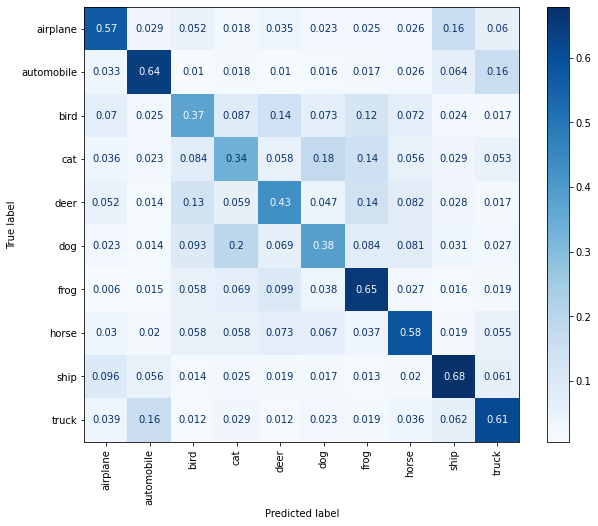

In [13]:
def plot_confusion_matrix(y_test,y_pred,display_labels=class_names,cmap=plt.cm.Blues):
    # Calculate the confusion matrix
    fig,ax = plt.subplots(1,figsize=(10,8))
    cm = confusion_matrix(y_test,y_pred,normalize='true')
    # Define the matrix display option
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
    disp.plot(cmap=cmap,ax=ax,xticks_rotation=90)

# Plot Confusion Matrix
print("MLP Confusion Matrix")
plot_confusion_matrix(y_test,mlp_y_pred)
plt.show()

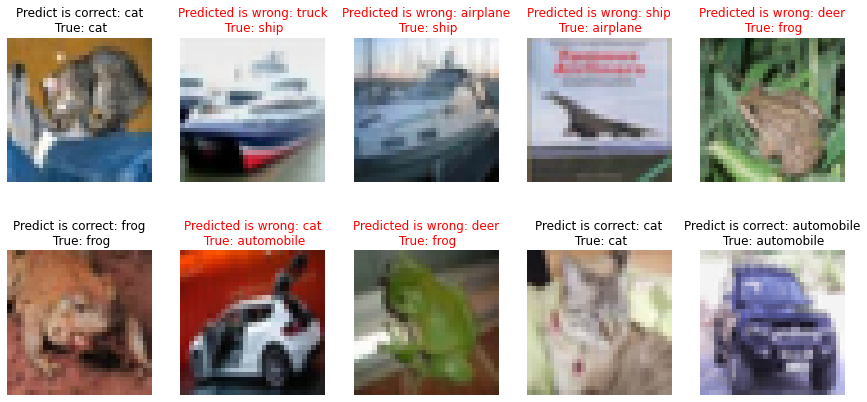

In [15]:
def predict_sample_images(images,true_labels,pred_labels,rows,cols,class_names):
    '''
    images:  X_train, X_valid, X_test(preferred)
    true_labels: x_test, ...,  y_test(preferred)
    pred_labels: mlp_y_pred, cnn_y_pred
    num: number of images to display
    '''
    num = rows * cols  # Define number of images to display
    plt.figure(figsize=(15,15))
    for i in range(num):
        if (pred_labels[i] == true_labels[i]):  # If prediction correct
            ax = plt.subplot(2*rows,cols,i+1)
            plt.imshow(images[i])
            plt.axis('off') 
            ax.set_title(f"Predict is correct: {class_names[pred_labels[i]]}\n True: {class_names[true_labels[i]]}")
        else:
            ax = plt.subplot(2*rows,cols,i+1)
            plt.imshow(images[i])
            plt.axis('off')
            ax.set_title(f"Predicted is wrong: {class_names[pred_labels[i]]}\n True: {class_names[true_labels[i]]}",color='red')
    plt.show()
    return

# MLP predict sample images
predict_sample_images(X_test,y_test,mlp_y_pred,2,5,class_names)

# 4. CNN Implementation
## 4.1 Design CNN Architecture
The MLP is composed of an input layer, one or more hidden layers, and an output layer with fully connected structure. In this Lab, the instruction has mentioned that:
+ Has 2 to 3 convolutional layers, add pooling layer between consecutive convolutional layers
+ Use batch normalisation layers to control the numerical values of the network weights
+ Has 1 to 2 fully connected layers before the output

### Convolutional 2D Layers
The convolutional neural network, so called CNN in abbreviation, is a specialised neural network model designed for analysing two-dimensional (2D) image data, Since our CNN model is aim to classify the colorful pixel images of 10 classes animals and others, applying 2D convolutional layers may give the best classification results.

### [Batch Normalisation Layers](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
The Batch Normalisation layers  are used to standardize raw input variables or the outputs of a layer. One certain concern is about adding Batch Norm before or after the Activation function of the previous layer. Although Batch Norm was placed in front of the activation block when it was proposed，most of the later studies have found that defining the activation function first before placing the BatchNorm gives better accuracy. Therefore, in my designed CNN, the Conv2D Layer with its activation has been defined first, then adding the BatchNorm (specifically located between the Conv2D Layer and MaxPooling Layer).

### [Max Pooling Layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)
When using the convolutional layer, we tend to also add a pooling layer for reducing the dimensionality of the output feature map. Thus reducing the number of learning parameters of the neural network, and optimizes the learning of the fully connected layer for the convolutional layer output. Therefore, the MaxPooling layers are added after the convolution layers, as suggested by the lab instruction.

### Fully Connected Layers
In my design CNN, the fully connected layers are decided as the same structure with our MLP network for better comparison **(in Section 5)**. We can consider my CNN network is the enhanced architecture of previous MLP network, by simply adding convolution layers and other elements. The output layer and its acivation also kept as same, since the Softmax performance is better in the multiclass classification task, and same 10 classes are corresponding to the network output.

In [16]:
# 4.1 - Design CNN architecture
def build_cnn_model(filters,kernel_size,act_func,
                    kernel_initializer='he_normal',learning_rate=0.1,dropout_rate=0.2):
    '''
    Parameters for optimal:
    > filters: 32, 64, 96, 128
    > kernel_size: 1, 2, ..., 5
    > activation : 'relu','tanh','sigmoid'
    '''
    # Build the model
    cnn_model = Sequential([
        # Input Layer and First Conv2D Layer
        keras.layers.Conv2D(filters,kernel_size,activation=act_func,input_shape=[32,32,3],name='Conv2D_1st'),
        keras.layers.BatchNormalization(name='BNorm_1st'),
        keras.layers.MaxPool2D(2,name='MPool_1st'),
        
        # Second Conv Layer
        keras.layers.Conv2D(filters*2,kernel_size,activation=act_func,name='Conv2D_2nd'),
        keras.layers.BatchNormalization(name='BNorm_2nd'),
        keras.layers.MaxPool2D(2,name='MPool_2nd'),
        
        # Fully Connected Layers
        keras.layers.Flatten(name='Flatten'),  
        keras.layers.Dense(512,activation=act_func,name='Dense_1st'),
        keras.layers.Dense(256,activation=act_func,name='Dense_2nd'),
        # Output Layer 
        keras.layers.Dense(10,activation='softmax',name='Output_Softmax') 
    ],name='CNN_Model')
    
    # Compile the model (learning_rate used here)
    cnn_model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return cnn_model

## 4.2 Optimal Parameters
Referring to Lab instruction, the optimal parameters from MLP implementation can directly used when we build the CNN model. That is: *kernel_initializer='he_normal', learning_rate=0.1* and *dropout_rate=0.2*. Furtherly, we have three new parameters `filters`,`kernel_size` and `activation` to be decided. **The GridSearchCV for explore optimal hyparameters has been commented out.**
```python
cnn_model = KerasClassifier(build_fn=build_cnn_model,verbose=0)
cnn_param = dict(filters=[32,64,128],
                 kernel_size=[1,3,5],
                 activation=['relu','tanh','sigmoid'])

cnn_grid = GridSearchCV(estimator=cnn_model,param_grid=cnn_param,n_jobs=-1,cv=3)
grid_result = cnn_grid.fit(X_valid,y_valid,epochs=30)
grid_result.best_params_
```
When initially building the model, I set epoches=100 and activated early stopping using the validation set. As the result, the initial CNN model will stop training around epoches=60. As we can guess, the CNN model will take longer time to train, so I set the `epochs=30` for `GridSearch` in order to find the most suitable parameters quickly.<br>

### Optimial Case

**The best optimal parameters:**<br>
+ (best) filters=128
+ (best) kernel_size=5
+ (best) **activation='relu'**
+ (best) epochs=30, the accuracy is 0.6919

When activation changed to 'sigmod':
+ filters=128
+ kernel_size=5
+ **activation='sigmod'**
+ (Worse) epochs=30, the accuracy is 0.6428

When activation changed to 'tanh':
+ filters=128
+ kernel_size=5
+ **activation='tanh'**
+ (Worse) epochs=30, the accuracy is 0.6106

### Activation function
Even if the number of filters is reduced or the size of the kernel changed, the CNN model using **ReLU** always shows the best performance. This may be caused by the use of the MLP optimal parameters, i.e., `kernel_initilizer='he_normal'`. Since the Lab sheet suggest us to use the MLP optimal parameters directly, I select ReLU as activation when building the CNN model in order to obtain the best performance from `he_normal` initialization.

### Kernel size and Filters (number of Kernels)
The common choice of Conv2d Layer kernel_size is between 3 till 5. While the kernel_size becomes larger, there are more weight contains in the Conv2D layer, and these weight coefficient. The filters define the number of computation to be performed. Therefore, when kernel_size and filters are increased at the same time, the CNN has a higher probability to calculate the accurate weights and thus obtain better prediction results.

## 4.3 Check the saved model existing or not

Here we will check my optimal CNN model is existing or not. This trained CNN model has been saved in a folder named **`'He_Zhanhong-CNN'`, if it is existing:** 
+ Load the saved model then display its architecture, 
+ Train the saved model with 1 more epoch, `verbose=2` to display epoch training progress

**If it is not exisitng:**
+ Build the new model with optimal params,
+ Train the new model with 100 epochs, `verbose=2` to display each epochs training progress
+ Save the new model.

In [21]:
# 4.3 - Check saved CNN model is existing or not
saved_cnn_name = 'He_Zhanhong-CNN'

if os.path.exists(saved_cnn_name) == True:
    
    # Load the saved CNN model if existing
    print(saved_cnn_name,' is existing in current directory. Loading the saved model')
    cnn_model = load_model(saved_cnn_name)
    cnn_model.summary() # Display its architecture
    # Train the saved model with 1 more epoch
    print('Training saved model with 1 more epoch')
    OneMoreEpoch_history = cnn_model.fit(X_train,y_train,epochs=1,
                                         validation_data=(X_valid,y_valid),verbose=2)

else:
    # Build the new CNN model if not existing (with best optimal params)
    print(saved_cnn_name,' not exising in current directory, building the new model')
    cnn_model = build_cnn_model(filters=128,kernel_size=5,act_func='relu')
    cnn_model.summary() # Display its architucture

    # Train the new model with 100 epochs
    print('Training new model with 100 epochs')
    HundredEpochs_history = cnn_model.fit(X_train,y_train,epochs=100,callbacks=callbacks,
                                          validation_data=(X_valid,y_valid),verbose=2)
    # Save the new model we trained
    save_model(cnn_model,saved_cnn_name)

He_Zhanhong-CNN  is existing in current directory. Loading the saved model
Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Conv2D_1st (Conv2D)    (None, 28, 28, 128)       9728      
_________________________________________________________________
BatchNorm_1st (BatchNormaliz (None, 28, 28, 128)       512       
_________________________________________________________________
MaxPool_1st (MaxPooling2D)   (None, 14, 14, 128)       0         
_________________________________________________________________
Conv2D_2nd (Conv2D)          (None, 10, 10, 256)       819456    
_________________________________________________________________
BatchNorm_2nd (BatchNormaliz (None, 10, 10, 256)       1024      
_________________________________________________________________
MaxPool_2nd (MaxPooling2D)   (None, 5, 5, 256)         0         
________________________________________________

## 4.4 Evaluate CNN Classification
This section will evalute the performance of CNN model we trained, including:
+ Classification Accuracy, Loss
+ Report the mean and different classes F1 score by `fiscore` and `classification_report`
+ Plot the Confusion matrix
+ Display CNN predict images example

Since the `plot_confussion_matrix` built-in sklearn.metrics does not supports our design models, we need to rewrite this function using `confusion_matrix` and `ConfusionMatrixDisplay`. This replacement function should able to display the confusion matrix of MLP classification result.

Furtherly, we will display some prediction results by design MLP model. If the prediction is correct, the images will be indexed with the black label, while the red labels means the model prediction is wrong.

In [22]:
# 4.4 - Evaluate MLP Classification
cnn_y_pred = np.argmax(cnn_model.predict(X_test),axis=-1)

# Classification Loss and Accuracy
cnn_score = cnn_model.evaluate(X_test,y_test,verbose=0)
print(f"CNN Classification Accuracy: {cnn_score[1]:.6f}, Loss: {cnn_score[0]:.6f}\n")

# Average F1 Score
print(f"CNN average F1 Score: {f1_score(y_test,cnn_y_pred,average='macro'):.6f}\n")

# Different Classes F1 Score
print(f"CNN different classes F1 Score:\n{classification_report(y_test,cnn_y_pred,target_names=class_names)}")

CNN Classification Accuracy: 0.672300, Loss: 1.042909

CNN average F1 Score: 0.669467

CNN different classes F1 Score:
              precision    recall  f1-score   support

    airplane       0.68      0.74      0.71      1000
  automobile       0.83      0.75      0.79      1000
        bird       0.50      0.63      0.56      1000
         cat       0.48      0.53      0.51      1000
        deer       0.64      0.62      0.63      1000
         dog       0.72      0.37      0.49      1000
        frog       0.81      0.66      0.73      1000
       horse       0.71      0.77      0.74      1000
        ship       0.74      0.83      0.78      1000
       truck       0.72      0.82      0.76      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000



CNN Confusion Matrix


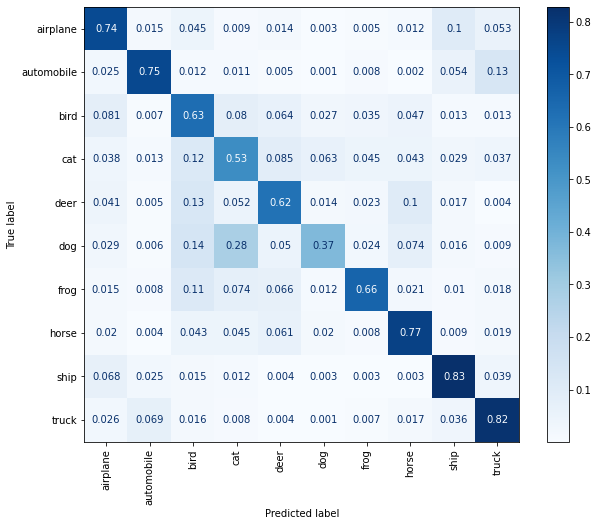

In [23]:
# Plot Confusion Matrix
print("CNN Confusion Matrix")
plot_confusion_matrix(y_test,cnn_y_pred)
plt.show()

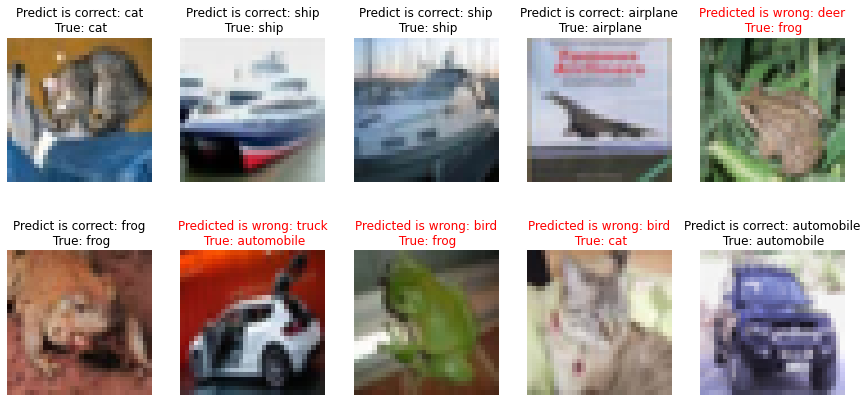

In [24]:
# CNN Predict images - 2 rows 5 columns
predict_sample_images(X_test,y_test,cnn_y_pred,2,5,class_names)

# 5. MLP and CNN Comparison
## Architecture
For the simple comparison, the CNN architecture I designed can be roughly considered as obtained by adding two Convolutional-2D Layers to the MLP baseline. 
## Classification Accuracy
Comparing the results of 3.4 and 4.4, it can be seen that the more complex structure of CNN improves the accuracy of the results, both in F1 Score and in Test Set, which is more than 10% higher than the MLP model.
## Running Time
The time to run the model is dependent on the computer's GPU; in my case with Google Colab, the time to train an additional epoch for the MLP model is about 2 seconds (see Section 3.3), while the time to train an epoch for the CNN is 8 seconds. This difference is caused by the complex structure. In practice, considering the time to tune the parameters, the time cost of designing a CNN is much larger than the MLP model.

## Confussion Matrix and F1 Score Matrix
In the matrices of confussion and f1score we can find that both MLP and CNN have high recognition errors for cats. However, CNN is good at recognizing other animals or vehicles.

## Predicted Images Illustration
Referring to Section 3.4 and 4.4, within that 10 random images are shown, the MLP was wrong 6 times out of 10 predictions, while the CNN was correct 8 times. This result visually illustrates the benefits of 2D convolutional layers and more complex architecture.


# 6. Appendix A
To visualise the MLP training process, we will built an new model without previous epochs training history, then plotting the training curve of this new model. To better observe the tend of accuracy during the training, we are not using the Callbacks to perform the early Stopping, and the verbose is set to 0 to skip the text content about each epoch history. 

From the plotting results, it can be clearly observed that the number of epochs and model training accuracy show an exponential correlation, which is the reason why **`expontional_scheduler`** should be used in **Section 3.2**.

```python
# Appendix A - Relationship between Epochs and MLP Accuracy
mlp_toplot = build_mlp_model(kernel_initializer='he_normal',learning_rate=0.1,dropout_rate=0.2)
mlp_history = mlp_toplot.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),verbose=0) #callbacks=callbacks,
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('Accuracy versus epochs')
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid(True)
plt.show()
```